### TP 3

Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para
filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada
de Fourier.
1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una
imagen para validar el funcionamiento en el dominio espectral.
2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.
3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of
focus measure operators in shape-from-focus”

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

#### FILTRADO ESPECTRAL

In [29]:
def create_gauss_filter(h,w,k_size,sigma):
    # creo un kernel gaussiano
    gauss_kernel = cv.getGaussianKernel(k_size, sigma)
    # expando el filtro a 2D
    gauss_filter = np.outer(gauss_kernel, gauss_kernel)
    # fourier transform del filtro gaussiano
    gauss_filter_fft = np.fft.fft2(gauss_filter, s=(h, w))
    return gauss_filter, gauss_filter_fft


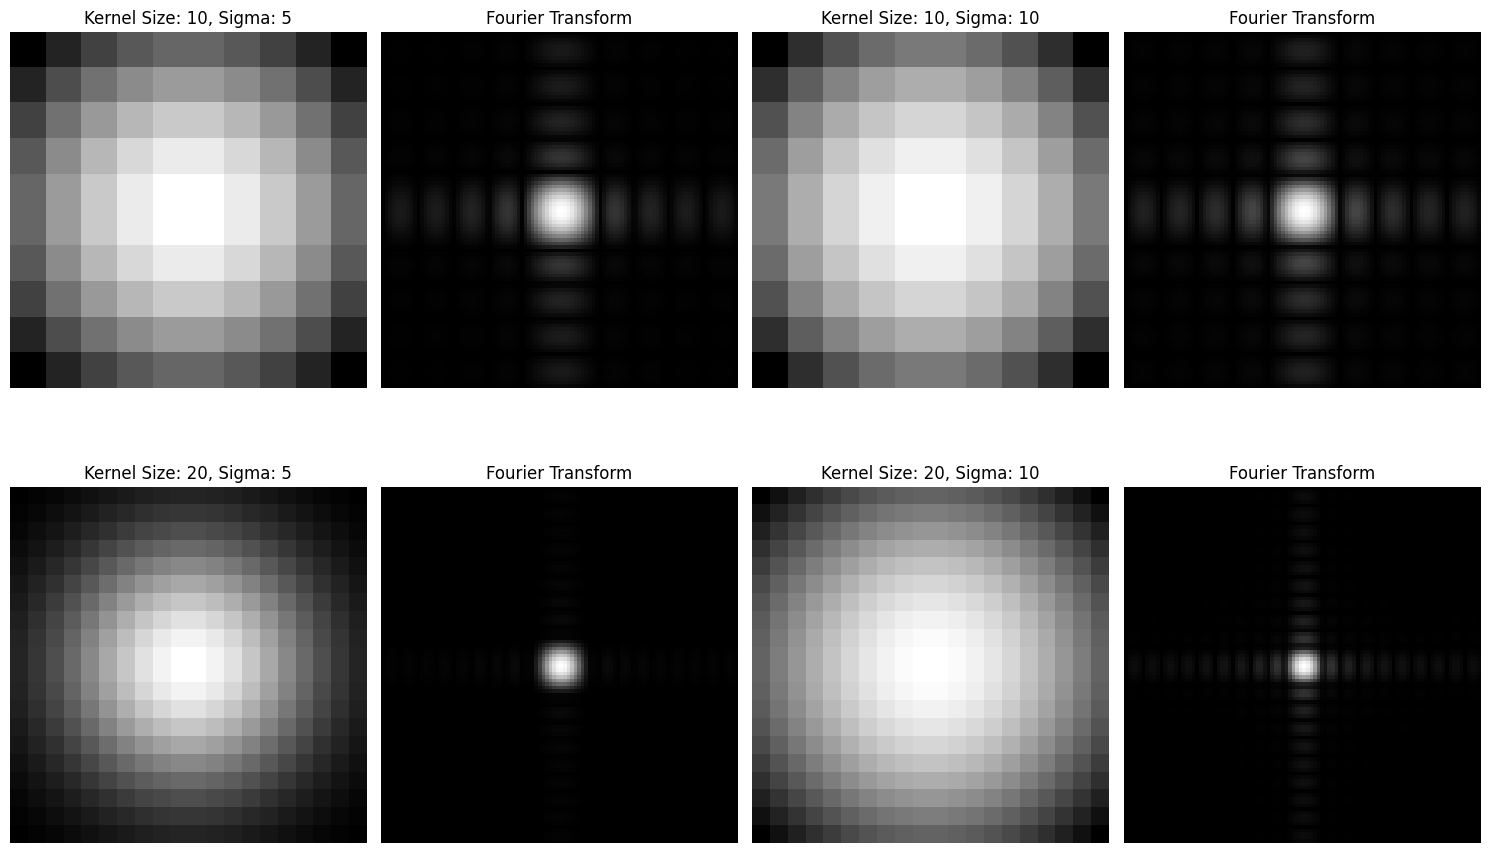

In [30]:
h, w = 100, 100
k_sizes = [10, 20]
sigmas = [5, 10]

plt.figure(figsize=(15, 5 * len(k_sizes)))

for i, k_size in enumerate(k_sizes):
    for j, sigma in enumerate(sigmas):
        gauss_filter, gauss_filter_fft = create_gauss_filter(h, w, k_size, sigma)
        
        plt.subplot(len(k_sizes), len(sigmas) * 2, i * len(sigmas) * 2 + j * 2 + 1)
        plt.imshow(gauss_filter, cmap='gray')
        plt.title(f'Kernel Size: {k_size}, Sigma: {sigma}')
        plt.axis('off')
        
        plt.subplot(len(k_sizes), len(sigmas) * 2, i * len(sigmas) * 2 + j * 2 + 2)
        plt.imshow(np.log(1 + np.abs(np.fft.fftshift(gauss_filter_fft))), cmap='gray')
        plt.title('Fourier Transform')
        plt.axis('off')

plt.tight_layout()
plt.show()

In [31]:
def apply_gauss_filter(h,w,k_size,sigma):
    # creo un kernel gaussiano
    gauss_kernel = cv.getGaussianKernel(k_size, sigma)
    # expando el filtro a 2D
    gauss_filter = np.outer(gauss_kernel, gauss_kernel)
    # fourier transform del filtro gaussiano
    gauss_filter_fft = np.fft.fft2(gauss_filter, s=(h, w))
    return gauss_filter_fft


In [99]:
image = cv.imread('./TP3/images/coca_logo_1.png', cv.IMREAD_GRAYSCALE)


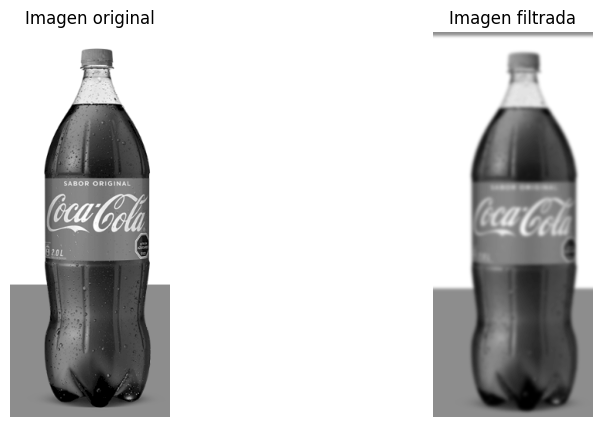

In [113]:
# Dimensiones de la imagen
h, w = image.shape

k_size = 11
sigma = 2

# Creo filtro gaussiano
gauss_filter_fft = apply_gauss_filter(h, w, k_size, sigma)

# transformada de fourier de la imagen
image_fft = np.fft.fft2(image)

# aplico filtro en el dominio espectral
filtered_image_fft = np.multiply(image_fft, gauss_filter_fft)

# inversa de la trasnformada para obtener la imagen filtrada
filtered_image = np.fft.ifft2(filtered_image_fft)
filtered_image = np.abs(filtered_image)
filtered_image = np.float32(filtered_image)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagen original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title('Imagen filtrada')
plt.axis('off')

plt.show()

#### FILTRADO POR CONVOLUCIÓN

In [114]:
def create_gauss_filter_conv(h, w, k_size, sigma):
    gauss_kernel_1d = cv.getGaussianKernel(k_size, sigma)
    gauss_filter = np.outer(gauss_kernel_1d, gauss_kernel_1d)
    return gauss_filter

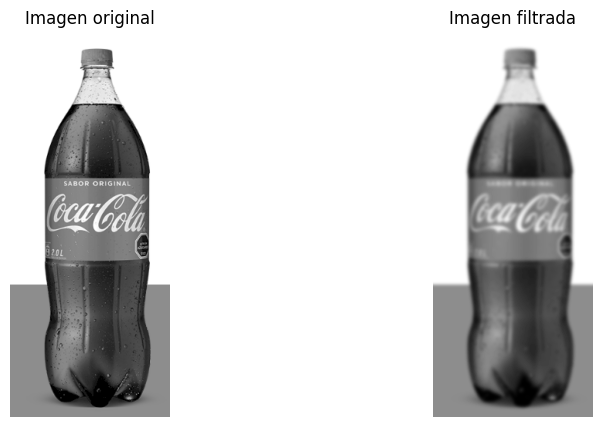

In [121]:
k_size = 11
sigma = 2

# creo filtro gausiano
gauss_filter = create_gauss_filter_conv(image.shape[0], image.shape[1], k_size, sigma)

# aplico el filtro a la imagen
filtered_image_conv = cv.filter2D(image, -1, gauss_filter)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.title('Imagen original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image_conv, cmap='gray')
plt.title('Imagen filtrada')
plt.axis('off')

plt.show()

#### MEDICIÓN DE BLURRINESS DE LAS IMAGENES PROPUESTA EN EL PAPER

## Algorithm for Image Quality Measure (FM)

This algorithm calculates the image quality measure (FM) of an image using the frequency domain. Higher FM values indicate better image quality (less blur).

**Input:**

* Image I of size M×N (numpy array)

**Output:**

* Image quality measure (FM)

**Steps:**

1. **Compute Fourier Transform (F):**
   - Calculate the Fast Fourier Transform (FFT) of the image I.

2. **Find Centered Fourier Transform (Fc):**
   - Shift the origin of F to the center using `fftshift`. This puts the low-frequency components in the center.

3. **Absolute Value (AF):**
   - Calculate the absolute value of the centered Fourier transform (Fc).

4. **Maximum Frequency Component (M):**
   - Find the maximum value in the absolute value array (AF).

5. **Threshold (thres):**
   - Set a threshold value (thres) as a proportion of the maximum value (M) - typically M/1000.

6. **Count High-Frequency Pixels (TH):**
   - Count the number of pixels in AF that are greater than the threshold (thres). These pixels correspond to high-frequency components in the image, which are less affected by blur.

7. **Image Quality Measure (FM):**
   - Calculate the FM using the following equation:
FM = T/(M*N)


In [122]:
from scipy.fft import fft2, fftshift

def freq_focus_measure(img):
    f = fft2(img)
    fc = fftshift(f)
    af = np.abs(fc)
    m = np.max(af)
    thres = m/1000
    th = np.sum(af > thres)
    fm = th / (img.shape[0] * img.shape[1])
    return fm

In [123]:
print('Quality measure original image:', freq_focus_measure(image))
print('Quality measure filtered image using frequency focus measure:', freq_focus_measure(filtered_image))
print('Quality measure filtered image using frequency focus measure:', freq_focus_measure(filtered_image_conv))


Quality measure original image: 0.04068599033816425
Quality measure filtered image using frequency focus measure: 0.016531400966183576
Quality measure filtered image using frequency focus measure: 0.017942028985507247


#### TENENGRAD VARIANCE - GRA7

Segun el paper *Analysis of focus measure operators for shape-from-focus*, el operador basado en gradiente GRA7 o Tenengrad variance muestra una muy buena respuesta al ruido.

$$ \phi_{x,y}=\sum_{(ij)\in\Omega(x,y)}(G(ij)-\overline{G})^{2},$$

This operator uses the variance of the image gradient as a focus measure. 


$\phi_{x,y}$: Varianza Tenengrad en el pixel$(x, y)$.

$\sum_{(ij)\in\Omega(x,y)}$: Esta suma itera sobre todos los pixeles vecinos$(i, j)$ dentro de una ventana o todos lso vecinos centrados en $(x, y)$, o sea $\Omega(x, y)$.

$G(ij)$: Valor de intensidad en el  pixel $(i, j)$.

$\overline{G}$: Intensidad promedio dentro de los pixeles vecinos $\Omega(x, y)$.

$(G(ij)-\overline{G})^{2}$: Calcula la diferencia al cuadrado entre la intensidad en $(i, j)$ y la intensidad promedio en los pixeles vecinos. 


Segun el paper citado Diatom autofocusing in brightfield microscopy: A comparative study (Pacheco et.al, 2000): "The method is based on computing the gradient magnitude
of a Sobel operator"


In [124]:
def tenengrad_variance(img):
    sx = cv.Sobel(img, cv.CV_32F, 1, 0, ksize=5)
    sy = cv.Sobel(img, cv.CV_32F, 0, 1, ksize=5)
    tenengrad = cv.magnitude(sx, sy)
    return tenengrad.var()

In [126]:
tenengrad_var_original = tenengrad_variance(image)
print("Varianza tenengrad de la imagen original", tenengrad_var_original)

tenengrad_var_fft_filtered = tenengrad_variance(filtered_image)
print("Varianza tenengrad de la imagen con filtrado espectral", tenengrad_var_fft_filtered)

tenengrad_var_conv_filtered = tenengrad_variance(filtered_image_conv)
print("Varianza tenengrad de la imagen con filtrado convolucional", tenengrad_var_conv_filtered)


Varianza tenengrad de la imagen original 1985400.9
Varianza tenengrad de la imagen con filtrado espectral 651606.5
Varianza tenengrad de la imagen con filtrado convolucional 621798.6


#### OBSERVACIONES
Observamos que a diferencia de las imagenes filtradas, la imagen original presenta una varianza alta. Esto podría indicar regiones con variaciones de textura significativas o bordes definidos. 

Por el contrario, las imagenes con filtro espectral y convolucional exhiben una varianza mas baja, lo que nos indica que la imagen esta desenfocada.

### MODIFIED LAPLACIAN

$$ \phi(x,y)=\sum_{(i,j)\in\Omega(x,y)}\Delta_{m}I(i,j) $$

En lugar de observar la varianza, observa los valores absolutos de la imagen filtrada

In [127]:
def Lx(img):
  kernelx = np.array([[0, 0, 0], [-1, 2, -1], [0, 0, 0]])
  return cv.filter2D(img, cv.CV_32F, np.array(kernelx))

def Ly(img):
  kernely = kernelx = np.array([[0, -1, 0], [0, 2, 0], [0, -1, 0]])
  return cv.filter2D(img, cv.CV_32F, np.array(kernely))

def modified_laplacian(img):
  return (np.abs(Lx(img)) + np.abs(Ly(img))).mean()

In [131]:
modified_laplacian_var_original = modified_laplacian(image)
print("Modified laplacian de la imagen original", modified_laplacian_var_original)

modified_laplacian_fft_filtered = modified_laplacian(filtered_image)
print("Modified laplacian de la imagen con filtrado espectral", modified_laplacian_fft_filtered)

modified_laplacian_conv_filtered = modified_laplacian(filtered_image_conv)
print("Varianza tenengrad de la imagen con filtrado convolucional", modified_laplacian_conv_filtered)


Modified laplacian de la imagen original 14.027536
Modified laplacian de la imagen con filtrado espectral 1.7010765
Modified laplacian de la imagen con filtrado convolucional 1.812773
